In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 함수 목록

In [67]:
# 두 좌표 사이 거리 측정 함수
def haversine(lat1, lon1, lat2, lon2):
    """
    두 좌표 사이의 실제 지구 표면 거리(km)를 계산.
    단순 유클리드 거리 대신 구면 기하학 공식을 사용해
    위도가 높아질수록 경도 간격이 좁아지는 왜곡을 보정함.
    """
    R = 6371  # 지구 반경 (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

# 좌표의 인접 초등학교 찾는 함수
def find_nearest_school(row, school_df):
    """
    school_df 전체와 거리를 한 번에 벡터 연산으로 계산 후
    거리가 최소인 행의 시설명을 반환.
    루프 없이 numpy 배열 연산을 쓰므로 데이터가 많아도 빠름.
    """
    distances = haversine(
        row['위도'], row['경도'],
        school_df['WGS84위도'].values,
        school_df['WGS84경도'].values
    )
    nearest_idx = np.argmin(distances)
    return school_df.iloc[nearest_idx]['시설명']

## 1. 경기도 성남시_생활안전 CCTV 설치 현황_20251112.csv
https://www.data.go.kr/data/15147955/fileData.do

In [3]:
cctv_df = pd.read_csv('./raw_data/경기도 성남시_생활안전 CCTV 설치 현황_20251112.csv')
cctv_df.sample(6)

,연번,시,구,동,관리번호,지번주소,도로명주소,설치일자,카메라대수,위도,경도,데이터기준일자
930,931.0,경기도 성남시,수정구,시흥동,수정시흥-A-16,시흥동 156-12번지,대왕판교로972번길 15 (시흥동),2017-12,5.0,37.427320,127.104150,2025-11-12
909,910.0,경기도 성남시,수정구,고등동,수정고등-A-73,고등동 605-2,NaN,2023-09,4.0,37.426758,127.097184,2025-11-12
1103,1104.0,경기도 성남시,중원구,중앙동,중원중앙-A-40,중앙동 3363-1,하늘채 랜더스 114동 앞,2022-12,5.0,37.438550,127.145737,2025-11-12
210,211.0,경기도 성남시,수정구,태평1동,수정태평1-A-55,태평1동 6973,성남대로 1235,2024-10,4.0,37.440313,127.127553,2025-11-12
799,800.0,경기도 성남시,수정구,위례동,수정위례-A-66,창곡동 537-1,위례서일로1길 19,2024-10,5.0,37.467399,127.136868,2025-11-12
2161,2162.0,경기도 성남시,분당구,이매2동,분당이매2-A-14,이매동 153-3,NaN,2020-07,4.0,37.395209,127.121957,2025-11-12


In [ ]:
cctv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3026 entries, 0 to 3025
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   연번       3024 non-null   float64
 1   시        3024 non-null   object 
 2   구        3024 non-null   object 
 3   동        3024 non-null   object 
 4   관리번호     3024 non-null   object 
 5   지번주소     3024 non-null   object 
 6   도로명주소    1616 non-null   object 
 7   설치일자     3024 non-null   object 
 8   카메라대수    3024 non-null   float64
 9   위도       3024 non-null   float64
 10  경도       3024 non-null   object 
 11  데이터기준일자  3024 non-null   object 
dtypes: float64(3), object(9)
memory usage: 283.8+ KB


In [30]:
cctv_df[cctv_df.isna().values.any(axis=1)]

,연번,시,구,동,관리번호,지번주소,도로명주소,설치일자,카메라대수,위도,경도,데이터기준일자
45,46.0,경기도 성남시,수정구,신흥2동,수정신흥2-A-2,신흥2동 6956,NaN,2021-06,4.0,37.451105,127.146177,2025-11-12
54,55.0,경기도 성남시,수정구,신흥2동,수정신흥2-A-13,신흥2동 6950,NaN,2024-10,3.0,37.455169,127.149695,2025-11-12
55,56.0,경기도 성남시,수정구,신흥2동,수정신흥2-A-14,신흥2동 2457-4,NaN,2023-02,5.0,37.446290,127.155437,2025-11-12
57,58.0,경기도 성남시,수정구,신흥2동,수정신흥2-A-16,신흥2동 2460-4,NaN,2022-01,5.0,37.446330,127.154490,2025-11-12
58,59.0,경기도 성남시,수정구,신흥2동,수정신흥2-A-17,신흥2동 2460-4,NaN,2022-01,5.0,37.446630,127.153720,2025-11-12
...,...,...,...,...,...,...,...,...,...,...,...,...
3021,3022.0,경기도 성남시,분당구,운중동,분당운중-D-7,대장동 246-11,NaN,2021-08,3.0,37.365102,127.068431,2025-11-12
3022,3023.0,경기도 성남시,분당구,운중동,분당운중-D-8,대장동 236,NaN,2021-08,3.0,37.363800,127.067150,2025-11-12
3023,3024.0,경기도 성남시,분당구,운중동,분당운중-D-9,대장동 239-3,NaN,2021-08,3.0,37.362757,127.067293,2025-11-12
3024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 연번 제거
cctv_df.drop(columns=['연번'], inplace=True)

In [32]:
# 전체 결측치인 행 제거 
cctv_df = cctv_df.dropna(subset=['시'])

In [34]:
cctv_df.isna().sum()

연번            0
시             0
구             0
동             0
관리번호          0
지번주소          0
도로명주소      1408
설치일자          0
카메라대수         0
위도            0
경도            0
데이터기준일자       0
dtype: int64

In [36]:
# 경도 컬럼 float로 변환
cctv_df['경도'] = pd.to_numeric(cctv_df['경도'], errors='coerce')
cctv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3024 entries, 0 to 3023
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   연번       3024 non-null   float64
 1   시        3024 non-null   object 
 2   구        3024 non-null   object 
 3   동        3024 non-null   object 
 4   관리번호     3024 non-null   object 
 5   지번주소     3024 non-null   object 
 6   도로명주소    1616 non-null   object 
 7   설치일자     3024 non-null   object 
 8   카메라대수    3024 non-null   float64
 9   위도       3024 non-null   float64
 10  경도       3023 non-null   float64
 11  데이터기준일자  3024 non-null   object 
dtypes: float64(4), object(8)
memory usage: 307.1+ KB


- 해당 지역이 어느 초등학교에 인접해있는지 컬럼 추가(조인시 기본 키로 활용) -> 일단 위치와 초등학교 이름 데이터가 필요할 듯

In [13]:
# 두 좌표 사이 거리 측정 함수
def haversine(lat1, lon1, lat2, lon2):
    """
    두 좌표 사이의 실제 지구 표면 거리(km)를 계산.
    단순 유클리드 거리 대신 구면 기하학 공식을 사용해
    위도가 높아질수록 경도 간격이 좁아지는 왜곡을 보정함.
    """
    R = 6371  # 지구 반경 (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

# 좌표의 인접 초등학교 찾는 함수
def find_nearest_school(row, school_df):
    """
    school_df 전체와 거리를 한 번에 벡터 연산으로 계산 후
    거리가 최소인 행의 시설명을 반환.
    루프 없이 numpy 배열 연산을 쓰므로 데이터가 많아도 빠름.
    """
    distances = haversine(
        row['위도'], row['경도'],
        school_df['WGS84위도'].values,
        school_df['WGS84경도'].values
    )
    nearest_idx = np.argmin(distances)
    return school_df.iloc[nearest_idx]['시설명']

## 1-1. 초등학교현황
https://data.gg.go.kr/portal/data/service/selectServicePage.do?page=1&rows=10&sortColumn=&sortDirection=&infId=0UH7S75R45EM2FTI971A20528353&infSeq=1&order=&loc=

In [14]:
school_df = pd.read_csv('./raw_data/초등학교현황.csv', encoding='cp949')
school_df

,설립구분명,시설명,전화번호,소재지지번주소,소재지도로명주소,소재지우편번호,WGS84위도,WGS84경도
0,공립,가림초등학교,02-803-3329,경기도 광명시 하안동 297번지,경기도 광명시 금당로 11-7,14305.0,37.458404,126.878378
1,공립,가평마장초등학교,031-582-2756,경기도 가평군 가평읍 마장리 357번지,경기도 가평군 가평읍 각담말길 15,12409.0,37.860144,127.514733
2,공립,가평초등학교,031-582-2491,경기도 가평군 가평읍 읍내리 553번지,경기도 가평군 가평읍 향교로 23,12417.0,37.831231,127.507739
3,공립,대성초등학교,031-584-0621,경기도 가평군 청평면 대성리 399-16번지,경기도 가평군 청평면 경춘로 75,12457.0,37.683125,127.377707
4,공립,목동초등학교,031-581-0615,경기도 가평군 북면 이곡리 13-45번지,경기도 가평군 북면 석장모루길 13,12407.0,37.879306,127.548123
...,...,...,...,...,...,...,...,...
1398,공립,다솜초등학교,031-932-8567,경기도 고양시 일산동구 풍동 1232번지,경기도 고양시 일산동구 숲속마을로 139,10303.0,37.672654,126.796583
1399,공립,신지초등학교,031-836-8123,경기도 양주시 백석읍 복지리 156번지,경기도 양주시 백석읍 양주산성로574번길 20,11510.0,37.788262,126.990184
1400,공립,다산한강초등학교,031-523-7500,경기도 남양주시 다산동 6236번지,경기도 남양주시 다산지금로146번길 11,12284.0,37.599431,127.172380
1401,공립,남양주다산초등학교,031-522-3200,경기도 남양주시 다산동 6049번지,경기도 남양주시 다산중앙로146번길 55,12285.0,37.626685,127.158570


In [15]:
school_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   설립구분명     1403 non-null   object 
 1   시설명       1403 non-null   object 
 2   전화번호      1403 non-null   object 
 3   소재지지번주소   1398 non-null   object 
 4   소재지도로명주소  1381 non-null   object 
 5   소재지우편번호   1385 non-null   float64
 6   WGS84위도   1382 non-null   float64
 7   WGS84경도   1382 non-null   float64
dtypes: float64(3), object(5)
memory usage: 87.8+ KB


In [16]:
school_df[school_df.isna().values.any(axis=1)]

,설립구분명,시설명,전화번호,소재지지번주소,소재지도로명주소,소재지우편번호,WGS84위도,WGS84경도
20,공립,백마초등학교장항분교장,031-301-2004,NaN,NaN,NaN,NaN,NaN
56,공립,지축초등학교,02-381-5166,NaN,NaN,NaN,NaN,NaN
214,공립,부천대명초등학교,070-7099-8504,경기도 부천시 오정구 오정동 127-8번지 부천대명초등학교,NaN,14426.0,37.527705,126.797177
383,공립,소래초등학교,031-311-9050,경기도 시흥시 호현로 27번길,NaN,NaN,NaN,NaN
518,공립,보라초등학교,031-282-2770,경기도 용인시 기흥구 금화로 105,NaN,17073.0,NaN,NaN
545,공립,지평초등학교일신분교장,0193321731,NaN,NaN,NaN,NaN,NaN
551,공립,점동초등학교뇌곡분교장,031-882-7549,NaN,NaN,NaN,NaN,NaN
570,공립,원삼초등학교두창분교장,031-322-8014,NaN,NaN,NaN,NaN,NaN
586,공립,발곡초등학교,031-878-8372,경기도 의정부시 동일로454번길,NaN,NaN,NaN,NaN
587,공립,배영초등학교,031-845-5402,경기도 의정부시 가능로 135,NaN,11686.0,NaN,NaN


In [17]:
# 일단 결측치가 있는 행은 제거. 결측치가 있는 행들이 성남 데이터가 아니므로 제거해도 무방할 것으로 판단됨
school_df = school_df.dropna()
school_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1381 entries, 0 to 1402
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   설립구분명     1381 non-null   object 
 1   시설명       1381 non-null   object 
 2   전화번호      1381 non-null   object 
 3   소재지지번주소   1381 non-null   object 
 4   소재지도로명주소  1381 non-null   object 
 5   소재지우편번호   1381 non-null   float64
 6   WGS84위도   1381 non-null   float64
 7   WGS84경도   1381 non-null   float64
dtypes: float64(3), object(5)
memory usage: 97.1+ KB


### cctv_df에 인접초등학교 컬럼 추가

In [37]:
cctv_df['인접초등학교'] = cctv_df.apply(
    lambda row: find_nearest_school(row, school_df), axis=1
)
print(cctv_df[['관리번호', '위도', '경도', '인접초등학교']])

           관리번호         위도          경도    인접초등학교
0     수정신흥1-A-1  37.439615  127.138008  성남수정초등학교
1     수정신흥1-A-2  37.438970  127.139560  성남중앙초등학교
2     수정신흥1-A-3  37.442144  127.141380    성남초등학교
3     수정신흥1-A-4  37.439805  127.141888  성남중앙초등학교
4     수정신흥1-A-5  37.440745  127.140138  성남중앙초등학교
...         ...        ...         ...       ...
3019   분당운중-D-5  37.368613  127.070169  판교대장초등학교
3020   분당운중-D-6  37.367721  127.070795  판교대장초등학교
3021   분당운중-D-7  37.365102  127.068431  판교대장초등학교
3022   분당운중-D-8  37.363800  127.067150    고기초등학교
3023   분당운중-D-9  37.362757  127.067293    고기초등학교

[3024 rows x 4 columns]


In [38]:
cctv_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3024 entries, 0 to 3023
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   연번       3024 non-null   float64
 1   시        3024 non-null   object 
 2   구        3024 non-null   object 
 3   동        3024 non-null   object 
 4   관리번호     3024 non-null   object 
 5   지번주소     3024 non-null   object 
 6   도로명주소    1616 non-null   object 
 7   설치일자     3024 non-null   object 
 8   카메라대수    3024 non-null   float64
 9   위도       3024 non-null   float64
 10  경도       3023 non-null   float64
 11  데이터기준일자  3024 non-null   object 
 12  인접초등학교   3024 non-null   object 
dtypes: float64(4), object(9)
memory usage: 330.8+ KB


In [39]:
cctv_df.describe()

,연번,카메라대수,위도,경도
count,3024.000000,3024.000000,3024.000000,3023.000000
mean,1512.500000,4.052249,37.414504,127.495445
std,873.097933,1.070728,0.034392,20.187442
min,1.000000,1.000000,37.298262,127.025003
25%,756.750000,4.000000,37.387183,127.111187
50%,1512.500000,4.000000,37.421725,127.130410
75%,2268.250000,5.000000,37.444438,127.147707
max,3024.000000,9.000000,37.474100,1237.069159


In [58]:
cctv_df.sample(5)

,시,구,동,관리번호,지번주소,도로명주소,설치일자,카메라대수,위도,경도,데이터기준일자,인접초등학교
1166,경기도 성남시,중원구,금광1동,중원금광1-A-49,금광1동 625,NaN,2023-07,4.0,37.442415,127.161952,2025-11-12,단남초등학교
2243,경기도 성남시,분당구,야탑2동,분당야탑2-A-7,야탑2동 515번지,NaN,2013,3.0,37.409183,127.129452,2025-11-12,돌마초등학교
788,경기도 성남시,수정구,위례동,수정위례-A-55,창곡동 510-3,성남시 수정구 창곡동 510-3,2022-07,4.0,37.471810,127.146690,2025-11-12,위례고운초등학교
163,경기도 성남시,수정구,태평1동,수정태평1-A-8,태평1동 6439번지,NaN,2010,4.0,37.441394,127.130523,2025-11-12,태평초등학교
85,경기도 성남시,수정구,신흥2동,수정신흥2-A-46,신흥2동 2344,공원로370번길 30,2021-12,5.0,37.447410,127.149860,2025-11-12,희망대초등학교


<Axes: xlabel='카메라대수', ylabel='Count'>

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:96: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:96: UserWarning: Glyph 47700 (\N{HANGUL SYLLABLE ME}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:96: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:96: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:96: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
C:\Users\USER\AppDa

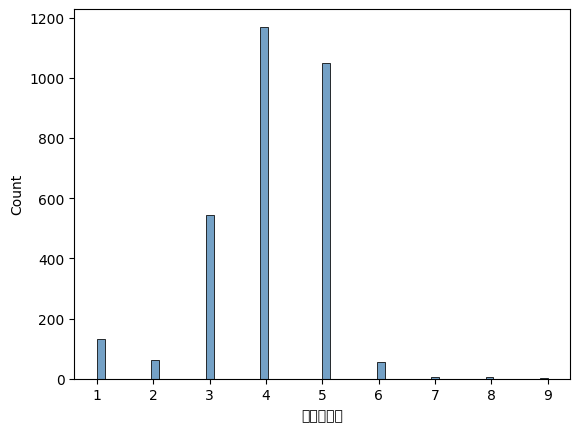

In [49]:
sns.histplot(cctv_df['카메라대수'], color='steelblue')

### 1. 처리 목록
- cctv 결측치 처리 : 전체 행이 다 결측치인 행만 제거
- cctv 경도 형변환 : object -> float
- 학교 위치 데이터 가져오기 및 결측치 처리 : 위도, 경도가 결측치인 행 제거(성남시 데이터가 아니라 그냥 제거함)
- cctv 위치에 학교 매핑 : 위도,경도 거리상 가장 인접한 학교로 매핑

In [63]:
cctv_df.to_csv('./생활안전cctv현황.csv')

## 2. 경기도_성남시_옐로카펫_설치현황
https://www.data.go.kr/data/15042521/fileData.do

In [52]:
yellowCarpet_df = pd.read_csv('./raw_data/경기도_성남시_옐로카펫_설치현황_20250617.csv', encoding='cp949')
yellowCarpet_df.head()

,연번,설치장소,설치도로명주소,설치지번주소,설치개소수,설치연도,관리기관전화번호,데이터기준일
0,1,태평초등학교,경기도 성남시 수정구 남문로32번길 7,경기도 성남시 수정구 태평동 3743,1,2016,031-729-3672,2025-06-17
1,2,늘푸른초등학교,경기도 성남시 분당구 정자일로 87,경기도 성남시 분당구 정자동 178-5,1,2016,031-729-3672,2025-06-17
2,3,오리초등학교,경기도 성남시 분당구 미금로 121,경기도 성남시 분당구 구미동 115,1,2016,031-729-3672,2025-06-17
3,4,상원초등학교,경기도 성남시 중원구 은행로 6,경기도 성남시 중원구 은행동 421,1,2017,031-729-3672,2025-06-17
4,5,금상초등학교,경기도 성남시 중원구 금상로 97 금상초등학교,경기도 성남시 중원구 금광동 1645,1,2017,031-729-3672,2025-06-17


In [53]:
yellowCarpet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   연번        85 non-null     int64 
 1   설치장소      85 non-null     object
 2   설치도로명주소   85 non-null     object
 3   설치지번주소    85 non-null     object
 4   설치개소수     85 non-null     int64 
 5   설치연도      85 non-null     int64 
 6   관리기관전화번호  85 non-null     object
 7   데이터기준일    85 non-null     object
dtypes: int64(3), object(5)
memory usage: 5.4+ KB


In [55]:
yellowCarpet_df['설치개소수'].value_counts()

설치개소수
1    83
2     2
Name: count, dtype: int64

In [60]:
yellowCarpet_df.drop(columns=['관리기관전화번호','연번'], inplace=True)

In [61]:
yellowCarpet_df['설치장소'].unique()

array(['태평초등학교', '늘푸른초등학교', '오리초등학교', '상원초등학교', '금상초등학교', '미금초등학교',
       '성남북초등학교', '성남혜은학교', '성남초등학교 ', '신백현초등학교', '중탑초등학교', '하원초등학교',
       '도촌초등학교', '희망대초등학교', '화랑초등학교', '정자초등학교', '운중초등학교', '중앙초등학교',
       '수진초등학교', '금빛초등학교', '복정초등학교', '은행초등학교', '검단초등학교', '대일초등학교',
       '성남동초등학교', '낙생초등학교', '산운초등학교', '야탑초등학교', '이매초등학교', '서당초등학교',
       '돌마초등학교', '불곡초등학교', '서현초등학교', '안말초등학교', '중원초등학교', '상대원초등학교',
       '여수초등학교', '왕남초등학교', '위례푸른초등학교', '단대초등학교', '수정초등학교', '수정북초등학교',
       '신흥초등학교', '단남초등학교', '판교초등학교', '내정초등학교', '당촌초등학교', '백현초등학교',
       '분당초등학교 ', '신기초등학교', '양영초등학교', '청솔초등학교', '탄천초등학교', '하탑초등학교',
       '수내초등학교', '양지초등학교', '성남서초등학교', '구미초등학교', '불정초등학교', '상탑초등학교',
       '매송초등학교', '장안초등학교', '초림초등학교', '한솔초등하교', '보평초등학교', '송현초등학교',
       '성수초등학교', '위례고운초등학교', '위례한빛초등학교', '위례중앙초등학교', '대원초등학교', '대하초등학교',
       '중부초등학교', '상탑사거리', '황송삼거리(사거리)'], dtype=object)

In [62]:
yellowCarpet_df.tail()

,설치장소,설치도로명주소,설치지번주소,설치개소수,설치연도,데이터기준일
80,성남초등학교,경기도 성남시 수정구 수정로233,경기도 성남시 수정구 태평4동 7326,1,2022,2025-06-17
81,중부초등학교,경기도 성남시 중원구 자혜로 55,경기도 성남시 중원구 은행1동 1932-7,1,2022,2025-06-17
82,수내초등학교,경기도 성남시 분당구 백현로243번길 12,경기도 성남시 분당구 수내동 81,1,2024,2025-06-17
83,상탑사거리,경기도 성남시 분당구 야탑로 225,경기도 성남시 분당구 야탑동 170-2,1,2024,2025-06-17
84,황송삼거리(사거리),경기도 성남시 중원구 황송로 4,경기도 성남시 중원구 금광동 2450-2,1,2024,2025-06-17


In [64]:
yellowCarpet_df.to_csv('./옐로카펫설치현황.csv')

## 3. 경기도아동안전지킴이집현황.csv
https://data.gg.go.kr/portal/data/service/selectServicePage.do?page=1&rows=10&sortColumn=&sortDirection=&infId=A484FNEWKSWX3IXUSJ1L29703862&infSeq=1&order=&loc=&downloadType=&SAFE_FACLT_NM=&REFINE_ROADNM_ADDR=&REFINE_LOTNO_ADDR=

- 수집기간 : 2019 - 2026-02-23           

In [65]:
child_shelter_df = pd.read_csv('./raw_data/경기도아동안전지킴이집현황.csv', encoding='cp949')
child_shelter_df.head()

,안전시설명,안전시설전화번호,소재지도로명주소,소재지지번주소,위도,경도,현존주소여부
0,우리자동차운전학원,031-582-0769,경기도 가평군 가평읍 태봉두밀로 34-71,경기도 가평군 가평읍 상색리 171-38번지,37.804569,127.486789,S
1,경희대튼튼체육관,031-582-6943,경기도 가평군 가평읍 석봉로 146,경기도 가평군 가평읍 읍내리 329-21번지,37.828148,127.511625,S
2,CU가평군청점,NaN,경기도 가평군 가평읍 석봉로 175,경기도 가평군 가평읍 읍내리 495-30번지,37.830591,127.510341,S
3,GS25가평군청점,031-582-5175,경기도 가평군 가평읍 석봉로 163,경기도 가평군 가평읍 읍내리 495-32번지,37.829716,127.510636,S
4,다래향,031-582-5552,경기도 가평군 가평읍 향교로 4,경기도 가평군 가평읍 읍내리 535번지,37.829653,127.510295,S


In [ ]:
# 성남시 안전지킴이집만 필터링
child_shelter_df = child_shelter_df[child_shelter_df['소재지도로명주소'].str.contains('성남', na=False)]

In [ ]:
child_shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 121 entries, 751 to 901
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   안전시설명     121 non-null    object 
 1   안전시설전화번호  109 non-null    object 
 2   소재지도로명주소  121 non-null    object 
 3   소재지지번주소   121 non-null    object 
 4   위도        121 non-null    float64
 5   경도        121 non-null    float64
 6   현존주소여부    121 non-null    object 
dtypes: float64(2), object(5)
memory usage: 7.6+ KB


In [72]:
child_shelter_df['현존주소여부'].unique()

array(['S', 'F'], dtype=object)

## 4. 상시교통량(일반국도시간대별) -> 패스

In [ ]:
traffic_df = pd.read_csv('./raw_data/상시교통량(일반국도시간대별).csv', encoding='cp949')
traffic_df.head()

,년도,월,일,호선명,호선코드,지점번호,상/하행,상/하행 코드,지역,지역코드,...,15~16시,16~17시,17~18시,18~19시,19~20시,20~21시,21~22시,22~23시,23~24시,전일합계
0,2024,1,29,일반국도 37호선,37,3719-01,상행,1,경기 여주 대신면,3128036,...,292,320,247,248,124,93,65,42,21,3733
1,2024,1,30,일반국도 3호선,3,0335-01,하행,0,경기 연천 청산면,3135032,...,1682,1572,1890,1716,877,644,528,371,223,23114
2,2024,1,30,일반국도 3호선,3,0328-02,하행,0,경기 여주 가남읍,3128011,...,1118,1154,1401,1125,574,481,362,240,131,16484
3,2024,1,30,일반국도 43호선,43,4305-00,하행,0,경기 광주 중부면,3125037,...,929,1073,1292,1273,576,359,287,186,116,14761
4,2024,1,30,일반국도 43호선,43,4304-02,하행,0,경기 광주 송정동,3125052,...,3199,3319,3757,3557,2246,1552,1383,784,462,49935


In [ ]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42304 entries, 0 to 42303
Data columns (total 36 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   년도       42304 non-null  int64 
 1   월        42304 non-null  int64 
 2   일        42304 non-null  int64 
 3   호선명      42304 non-null  object
 4   호선코드     42304 non-null  int64 
 5   지점번호     42304 non-null  object
 6   상/하행     42304 non-null  object
 7   상/하행 코드  42304 non-null  int64 
 8   지역       42304 non-null  object
 9   지역코드     42304 non-null  int64 
 10  주변분기점    42304 non-null  object
 11  00~01시   42304 non-null  int64 
 12  01~02시   42304 non-null  int64 
 13  02~03시   42304 non-null  int64 
 14  03~04시   42304 non-null  int64 
 15  04~05시   42304 non-null  int64 
 16  05~06시   42304 non-null  int64 
 17  06~07시   42304 non-null  int64 
 18  07~08시   42304 non-null  int64 
 19  08~09시   42304 non-null  int64 
 20  09~10시   42304 non-null  int64 
 21  10~11시   42304 non-null  int64 
 22

## 5. 경기도 성남시_관공서 및 주요기관 정보_20251126.csv
https://www.data.go.kr/data/15032489/fileData.do

- 수집 일자: ~ 2025-11-26

In [ ]:
police_station_df = pd.read_csv('./raw_data/경기도 성남시_관공서 및 주요기관 정보_20251126.csv')
police_station_df.head()

,구 분,기관명,소 재 지,관할구역,전화번호,데이터기준일자
0,분당구,성남교육지원청,경기도 성남시 분당구 양현로 20,성남시,031-780-2500,2025-11-26
1,수정구,성남세무서,경기도 성남시 수정구 희망로 480,"성남시 수정구, 중원구",031-730-6200,2025-11-26
2,분당구,분당세무서,경기도 성남시 분당구 분당로 23,성남시 분당구,031-219-9200,2025-11-26
3,법원(지원),수원지방법원성남지원,경기도 성남시 수정구 산성대로 451,성남시,031-737-1114,2025-11-26
4,등기소,성남지원등기소,경기도 성남시 수정구 산성대로 451,성남시,1544-0773,2025-11-26


In [ ]:
keywords = ['파출소', '지구대', '치안센터', '경찰서']
pattern = '|'.join(keywords)  
police_station_df = police_station_df[police_station_df['기관명'].str.contains(pattern, na=False)]
police_station_df.head()

,구 분,기관명,소 재 지,관할구역,전화번호,데이터기준일자
7,수정구,성남수정경찰서,경기도 성남시 성남대로 1259,수정구,031-182,2025-11-26
8,수정구,수진지구대,경기도 성남시 수정구 모란로 1,"태평1동, 수진2동",031-750-4020,2025-11-26
9,수정구,신흥지구대,경기도 성남시 수정구 시민로 150,"신흥1동, 신흥2동, 신흥3동",031-750-4030,2025-11-26
10,수정구,고등파출소,경기도 성남시 수정구 고등공원로 47,"신촌동, 오야동 등 9개동",031-750-4050,2025-11-26
11,수정구,복정파출소,경기도 성남시 수정구 복정로 36,복정동,031-750-4060,2025-11-26


In [ ]:
police_station_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, 7 to 34
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   구 분      28 non-null     object
 1   기관명      28 non-null     object
 2   소 재 지    28 non-null     object
 3   관할구역     28 non-null     object
 4   전화번호     28 non-null     object
 5   데이터기준일자  28 non-null     object
dtypes: object(6)
memory usage: 1.5+ KB


## 6. 경기도 성남시_도로상 조명시설 지오태깅 데이터_20221216
https://www.data.go.kr/data/15110582/fileData.do

- 수집일자: 2022-12-16 ~ 2025-11-13

In [ ]:
lamp_df = pd.read_csv('./raw_data/경기도 성남시_도로상 조명시설 지오태깅 데이터_20221216.csv', encoding='cp949')
lamp_df.head()

,순번(NO),구분(LAMP),일련번호(SER),위도(LATITUDE),경도(LONGITUDE)
0,1,2,고기로-1,37.352327,127.082932
1,2,2,고기로-2,37.352327,127.082932
2,3,2,고기로-3,37.352327,127.082932
3,4,2,구미로-1,37.343812,127.124693
4,5,2,구미로-2,37.343812,127.124693


In [ ]:
lamp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33568 entries, 0 to 33567
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   순번(NO)         33568 non-null  int64  
 1   구분(LAMP)       33568 non-null  int64  
 2   일련번호(SER)      33568 non-null  object 
 3   위도(LATITUDE)   33568 non-null  float64
 4   경도(LONGITUDE)  33568 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.3+ MB


## 7.경기도 성남시_인구및세대_현황_20260131
https://www.data.go.kr/data/15007386/fileData.do

- 수집일자: ~2026-02-03

In [ ]:
population_df = pd.read_csv('./raw_data/경기도 성남시_인구및세대_현황_20260131.csv')
population_df.head()

,구별,동,인구수_계,인구수_남,인구수_여,19세 이상_계,19세 이상_남,19세 이상_여,65세 이상_계,65세 이상_남자,65세 이상_여자,세대수,재외국민,데이터기준일자
0,수정구,신흥1동,11999,6416,5583,11277,6041,5236,3142,1377,1765,7417,19,2026-01-31
1,수정구,신흥2동,31620,15355,16265,26664,12853,13811,5248,2426,2822,12302,49,2026-01-31
2,수정구,신흥3동,10632,5718,4914,9957,5373,4584,2616,1227,1389,6436,9,2026-01-31
3,수정구,태평1동,13508,7011,6497,12791,6659,6132,3599,1591,2008,8214,22,2026-01-31
4,수정구,태평2동,13600,6853,6747,12562,6350,6212,3388,1453,1935,7525,17,2026-01-31


In [ ]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   구별         50 non-null     object
 1   동          50 non-null     object
 2   인구수_계      50 non-null     int64 
 3   인구수_남      50 non-null     int64 
 4   인구수_여      50 non-null     int64 
 5   19세 이상_계   50 non-null     int64 
 6   19세 이상_남   50 non-null     int64 
 7   19세 이상_여   50 non-null     int64 
 8   65세 이상_계   50 non-null     int64 
 9   65세 이상_남자  50 non-null     int64 
 10  65세 이상_여자  50 non-null     int64 
 11  세대수        50 non-null     int64 
 12  재외국민       50 non-null     int64 
 13  데이터기준일자    50 non-null     object
dtypes: int64(11), object(3)
memory usage: 5.6+ KB


=> 아동 수가 없지만 일단 패스하겠다..

## 8. 202512_202512_연령별인구현황_연간
https://jumin.mois.go.kr/ageStatMonth.do#none

- 수집 기간: 25년 (25년 1년간 )

In [ ]:
child_population_df = pd.read_csv('./raw_data/202512_202512_연령별인구현황_연간.csv', encoding='cp949')
child_population_df.head()

,행정구역,2025년_계_총인구수,2025년_계_연령구간인구수,2025년_계_0~4세,2025년_계_5~9세,2025년_계_10~14세,2025년_계_15~19세,2025년_남_총인구수,2025년_남_연령구간인구수,2025년_남_0~4세,2025년_남_5~9세,2025년_남_10~14세,2025년_남_15~19세,2025년_여_총인구수,2025년_여_연령구간인구수,2025년_여_0~4세,2025년_여_5~9세,2025년_여_10~14세,2025년_여_15~19세
0,경기도 성남시 (4113000000),"905,794","135,396","23,841","30,320","40,148","41,087","447,380","69,062","12,224","15,421","20,581","20,836","458,414","66,334","11,617","14,899","19,567","20,251"
1,경기도 성남시 수정구 (4113100000),"232,389","28,654","5,925","6,772","7,725","8,232","117,449","14,523","3,039","3,434","3,886","4,164","114,940","14,131","2,886","3,338","3,839","4,068"
2,경기도 성남시 수정구 신흥1동(4113151000),"12,046",810,101,139,248,322,"6,439",416,53,72,128,163,"5,607",394,48,67,120,159
3,경기도 성남시 수정구 신흥2동(4113152000),"31,635","5,231","1,621","1,410","1,078","1,122","15,368","2,624",810,727,543,544,"16,267","2,607",811,683,535,578
4,경기도 성남시 수정구 신흥3동(4113153000),"10,670",748,122,143,198,285,"5,735",381,68,68,95,150,"4,935",367,54,75,103,135


In [ ]:
child_population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   행정구역             54 non-null     object
 1   2025년_계_총인구수     54 non-null     object
 2   2025년_계_연령구간인구수  54 non-null     object
 3   2025년_계_0~4세     54 non-null     object
 4   2025년_계_5~9세     54 non-null     object
 5   2025년_계_10~14세   54 non-null     object
 6   2025년_계_15~19세   54 non-null     object
 7   2025년_남_총인구수     54 non-null     object
 8   2025년_남_연령구간인구수  54 non-null     object
 9   2025년_남_0~4세     54 non-null     object
 10  2025년_남_5~9세     54 non-null     object
 11  2025년_남_10~14세   54 non-null     object
 12  2025년_남_15~19세   54 non-null     object
 13  2025년_여_총인구수     54 non-null     object
 14  2025년_여_연령구간인구수  54 non-null     object
 15  2025년_여_0~4세     54 non-null     object
 16  2025년_여_5~9세     54 non-null     object
 17  2025년_여_10~14세   54 non-null     obje